In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
import datetime
import os
import torch
from pkg import DEVICE
from utils import NEURONS_302
from models._utils import *
from scipy import stats

In [3]:
%matplotlib inline

In [4]:
sl_log_dir = '/om2/user/lrvenan/worm-graph/logs/SGD_rnn/num_worms' # Path to the folder with all logs from the scaling laws experiment

# Time per epoch
---

- Time per epoch vs. number of worms
- Time per epoch vs. numer of named neurons

In [29]:
def time_per_epoch_plot(exp_log_dir, key='num_worms'):
    if key == 'num_worms':
        key_name = 'Number of worms'
    elif key == 'num_named_neurons':
        key_name = 'Number of named neurons'
    else:
        raise ValueError('key must be num_worms or num_named_neurons')

    # Store seconds per epoch, number of named neurons and number of worms
    seconds_per_epoch = []
    num_named_neurons = []
    num_worms = []

    # Loop over all folders inside the log directory
    for folder in os.listdir(sl_log_dir):
        # Load the config file inside each folder
        config = OmegaConf.load(os.path.join(sl_log_dir, folder, 'config.yaml'))
        # Extract seconds_per_epoch from the config file
        seconds_per_epoch.append(config['globals']['seconds_per_epoch'])
        # Extract num_named_neurons from the config file
        num_named_neurons.append(config['dataset']['num_named_neurons'])
        # Extract num_worms from the config file
        num_worms.append(config['dataset']['num_worms'])

    # Create a dataframe with the seconds per epoch, number of named neurons and number of worms
    df = pd.DataFrame({'seconds_per_epoch': seconds_per_epoch, 'num_named_neurons': num_named_neurons, 'num_worms': num_worms})

    # Plot the seconds per epoch vs the number of worms
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(data=df, x='num_worms', y='seconds_per_epoch', ax=ax)
    # Use log scale for the x axis and y axis
    ax.set_xscale('log')
    ax.set_yscale('log')
    # Use whitegrid style
    sns.set_style('whitegrid')
    # Set the x axis and y axis labels according to the key
    plt.xlabel(key_name)
    plt.ylabel('Seconds per epoch')
    # Set title according to the key
    plt.title('Seconds per epoch vs {}'.format(key_name))
    plt.tight_layout()
    plt.show()

    # Return df, fig and ax so we can customize the plot if we want
    return df, fig, ax

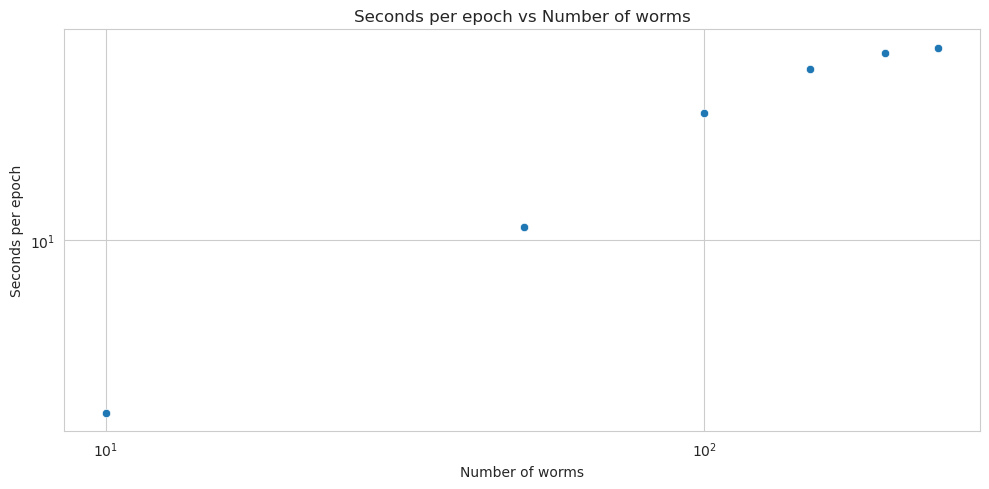

In [30]:
df, fig, ax = time_per_epoch_plot(sl_log_dir, key='num_worms')

In [31]:
# Regression line for the plot above
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df['num_worms']), np.log(df['seconds_per_epoch']))
print('Regression line: y = {}x + {}'.format(slope, intercept))
# Add the regression line to the plot above using sns lineplot
x = np.linspace(1, df['num_worms'].max(), 1000)
y = np.exp(intercept) * x ** slope
# Write the regression line equation as a label
label = 'y = {}x + {}'.format(round(slope, 2), round(intercept, 2))
sns.lineplot(x=x, y=y, ax=ax, label=label, color='red')
# Use dashed line style
ax.lines[0].set_linestyle("--")
# Reduce the opacity of the regression line
ax.lines[0].set_alpha(0.5)
# Reduce size of the regression line
ax.lines[0].set_linewidth(1)
# Save the plot
fig.savefig('seconds_per_epoch_vs_num_worms.png', dpi=300)

Regression line: y = 1.0480236686493551x + -1.5952570804614652


# Amount of data
---

In [5]:
sl_log_dir = '/om2/user/lrvenan/worm-graph/logs/SGD_rnn/num_worms' # Path to the folder with all logs from the scaling laws experiment

In [32]:
def test_losses_plot(exp_log_dir):
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.set_style('whitegrid')
    sns.set_palette('tab10')

    # Loop over all folders inside the log directory
    for folder in os.listdir(exp_log_dir):
        # Load the config file inside each folder
        config = OmegaConf.load(os.path.join(exp_log_dir, folder, 'config.yaml'))
        # Extract the number of worms
        num_worms = config['dataset']['num_worms']
        # Load the dataframe with the losses
        loss_df = pd.read_csv(os.path.join(exp_log_dir, folder, 'loss_curves.csv'))
        # Plot the test losses
        label = '{} worms'.format(num_worms)
        sns.lineplot(data=loss_df, x='epochs', y='test_losses', ax=ax, label=label)

    # Set the x axis and y axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Test loss')
    # Set title
    plt.title('Test loss vs epochs')
    plt.tight_layout()
    # Save the plot
    fig.savefig('test_loss_vs_epochs.png', dpi=300)
    plt.show()

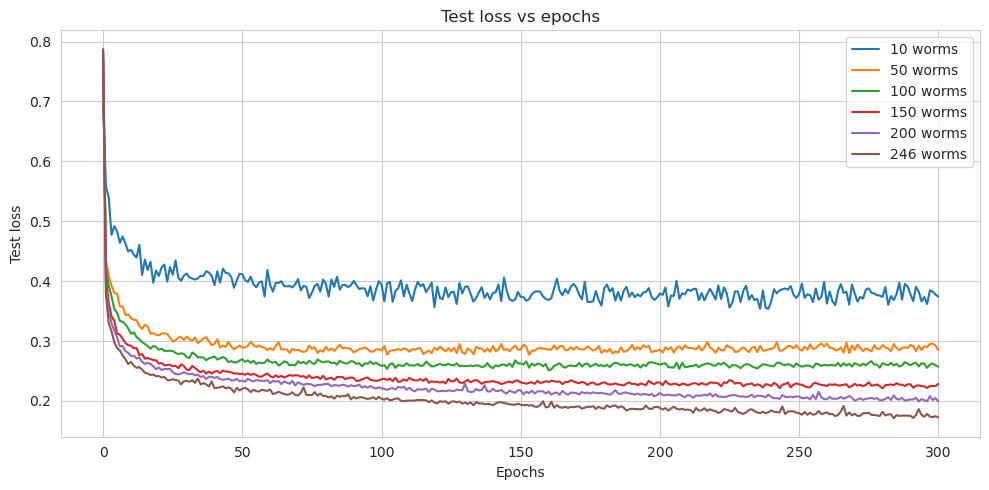

In [33]:
test_losses_plot(sl_log_dir)

In [34]:
def find_plateau_epoch(loss_df, threshold):
    # Extract losses and epochs from the loss dataframe
    test_losses = loss_df['test_losses'].values
    epochs = loss_df['epochs'].values

    # Loop over 100 window sizes
    for window_size in range(10, 110):
        # Calculate a moving average of the test losses to smooth the curve
        smoothed_losses = np.convolve(test_losses, np.ones(window_size)/window_size, mode='valid')

        # Calculate the derivative of the smoothed losses
        derivatives = np.diff(smoothed_losses)

        # Identify the epoch when the absolute derivative first becomes close to zero.
        plateau_epoch = next((i for i, deriv in enumerate(derivatives) if abs(deriv) < threshold), None)

        # If the plateau epoch is not None, then we found the epoch when the loss curve plateaus
        if plateau_epoch is not None:
            # Return the plateau epoch and the mean loss after the plateau epoch
            plateau_mean_loss = np.mean(test_losses[plateau_epoch-window_size//2:plateau_epoch+window_size//2])
            return plateau_epoch, plateau_mean_loss, window_size, threshold
        
    # If plateau epoch is None, increase the threshold and try again
    return find_plateau_epoch(loss_df, threshold * 1.2)

In [39]:
def plateau_epoch_per_amount_data_plot(exp_log_dir, threshold=1e-6, plateau_plot=False):

    # Store plateau epoch, window size and threshold for each log folder
    plateau_epochs = []
    window_sizes = []
    thresholds = []

    # Store number of worms and mean loss after plateau
    num_worms = []
    plateau_losses = []

    # Loop over the folders inside the log directory
    for folder in os.listdir(sl_log_dir):
        # Load the config file inside each folder
        config = OmegaConf.load(os.path.join(sl_log_dir, folder, 'config.yaml'))
        # Extract num_worms from the config file
        num_worms.append(config['dataset']['num_worms'])
        # Load the loss dataframe inside each folder
        loss_df = pd.read_csv(os.path.join(sl_log_dir, folder, 'loss_curves.csv'))
        # Find the epoch when the loss curve plateaus
        plateau_epoch, plateau_loss, window_size, threshold = find_plateau_epoch(loss_df, threshold)
        # Store plateau epoch, mean loss, window size and threshold
        plateau_epochs.append(plateau_epoch)
        plateau_losses.append(plateau_loss)
        window_sizes.append(window_size)
        thresholds.append(threshold)

        # Plot the smoothed loss curve
        if plateau_plot:
            # Extract losses and epochs from the loss dataframe
            test_losses = loss_df['test_losses'].values
            epochs = loss_df['epochs'].values
            # Plot the test losses and the plateau epoch
            fig, ax = plt.subplots(figsize=(10, 5))
            sns.lineplot(x=epochs, y=test_losses, ax=ax)
            sns.set_style('whitegrid')
            sns.set_palette('tab10')
            ax.axvline(x=plateau_epoch, color='red', linestyle='--', label='Plateau epoch (around {})\n~ threshold: {}\n~ window size: {}'.format(plateau_epoch, threshold, window_size))
            plt.xlabel('Epoch')
            plt.ylabel('Test loss')
            plt.title('Test loss vs epoch')
            plt.legend(loc='upper right')
            plt.tight_layout()
            # Save the plot
            fig.savefig('plateau_{}.png'.format(folder), dpi=300)
            plt.close()

    # Create a dataframe with the plateau epoch, window size and threshold
    df = pd.DataFrame({'num_worms': num_worms, 'plateau_epoch': plateau_epochs, 'plateau_loss': plateau_losses, 'window_size': window_sizes, 'threshold': thresholds})

    # Plot plateau loss vs number of worms
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(data=df, x='num_worms', y='plateau_loss', ax=ax)
    # Use log scale for the x axis and y axis
    ax.set_xscale('log')
    ax.set_yscale('log')
    # Use whitegrid style
    sns.set_style('whitegrid')
    sns.set_palette('tab10')
    # Set the x axis and y axis labels according to the key
    plt.xlabel('Number of worms')
    plt.ylabel('Test (plateau) loss')
    # Set title
    plt.title('Test (plateau) loss vs number of worms')
    plt.tight_layout()
    plt.show()

    return df, fig, ax

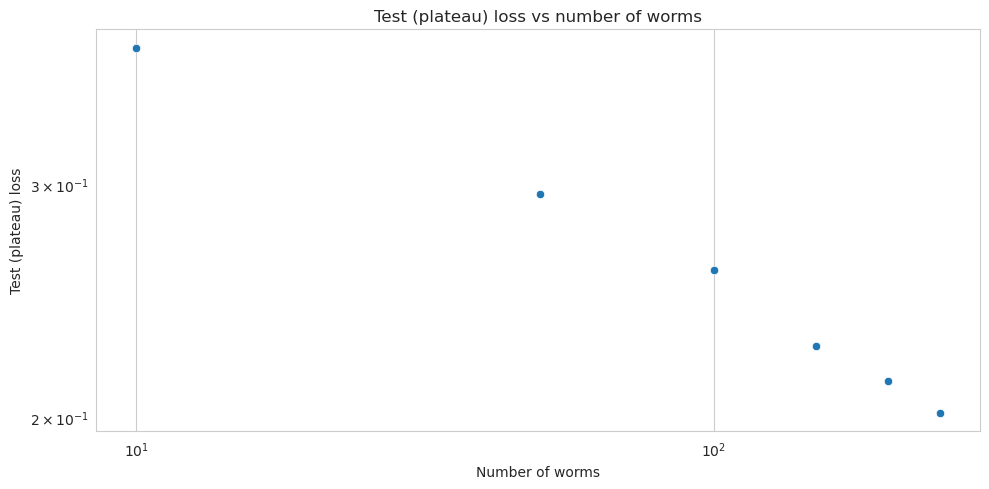

In [40]:
df, fig, ax = plateau_epoch_per_amount_data_plot(sl_log_dir, threshold=1e-6, plateau_plot=True)

In [41]:
# Regression line for the plot above
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df['num_worms']), np.log(df['plateau_loss']))
print('Regression line: y = {}x + {}'.format(slope, intercept))
# Add the regression line to the plot above using sns lineplot
x = np.linspace(df['num_worms'].min(), df['num_worms'].max(), 1000)
y = np.exp(intercept) * x ** slope
# Write the regression line equation as a label
label = 'y = {}x + {}'.format(round(slope, 2), round(intercept, 2))
sns.lineplot(x=x, y=y, ax=ax, label=label, color='red')
# Use dashed line style
ax.lines[0].set_linestyle("--")
# Reduce the opacity of the regression line
ax.lines[0].set_alpha(0.5)
# Reduce size of the regression line
ax.lines[0].set_linewidth(1)
# Save the plot
fig.savefig('plateau_loss_vs_num_worms.png', dpi=300)

Regression line: y = -0.19764490544014698x + -0.4854296113357429
